<a href="https://colab.research.google.com/github/kp0402/demopygit/blob/main/visual_object_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 14474, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 14474 (delta 65), reused 68 (delta 42), pack-reused 14371
Receiving objects: 100% (14474/14474), 13.66 MiB | 30.61 MiB/s, done.
Resolving deltas: 100% (9959/9959), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


 # FOR UPDATING YOLOV5 

 this is because yolov5 gets constantly update in real time 

In [2]:
!git pull https://github.com/ultralytics/yolov5

From https://github.com/ultralytics/yolov5
 * branch            HEAD       -> FETCH_HEAD
Updating fbe67e4..357cde9
Fast-forward
 utils/docker/.dockerignore => .dockerignore |    2 +-
 .github/README_cn.md                        |  291 ------
 .github/workflows/ci-testing.yml            |  134 ++-
 .github/workflows/docker.yml                |    3 +
 .github/workflows/greetings.yml             |   22 +-
 .github/workflows/rebase.yml                |   21 -
 .github/workflows/stale.yml                 |    2 +-
 .github/workflows/translate-readme.yml      |   27 +
 .pre-commit-config.yaml                     |   14 +-
 CITATION.cff                                |   14 +
 CONTRIBUTING.md                             |   23 +-
 README.md                                   |  486 ++++++---
 README.zh-CN.md                             |  482 +++++++++
 utils/benchmarks.py => benchmarks.py        |   32 +-
 classify/predict.py                         |  226 ++++
 classify/train.py            

  # Installing Requirements for yolov5

In [3]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)


     |████████████████████████████████| 182 kB 5.0 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 1.6 MB 73.5 MB/s 


# Setting up GPUs of google Colab to run yolov5

In [4]:
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.13.0+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


# Downloading dataset directly from roboflow

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="c3C6eciXJl8EjBEfur9S")
project = rf.workspace("mcmaster-v90vf").project("visual_object_tracking")
dataset = project.version(2).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 894 kB/s 
     |████████████████████████████████| 145 kB 8.4 MB/s 
     |████████████████████████████████| 178 kB 39.8 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 138 kB 68.7 MB/s 
     |████████████████████████████████| 54 kB 1.7 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=cc59e22a7893fd7f388023f87dc13e2f95331988116d7a331cd72eb7ec795b2d
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: certifi
    Found existing installation: certif

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to visual_object_tracking-2 in yolov5pytorch:: 100%|██████████| 6176/6176 [00:01<00:00, 3630.51it/s]


# Defining Number of Classes


In [6]:
import yaml
with open("/content/yolov5/visual_object_tracking-2/data.yaml", 'r') as rf:
    all_classes = str(yaml.safe_load(rf)['nc'])

# Model we will use for detection

In [7]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

# Training YOLOv5 Detector

Here we use image size of 640 * 640

batch size = 64

and we run this for 100 epochs using yolov5s model

saving weights with name yolov5s_results 

caching the image for faster training


In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5
!python train.py --img 640 --batch 64 --epochs 100 --data '/content/yolov5/visual_object_tracking-2/data.yaml' --cfg ./models/yolov5s.yaml --weights '' --name yolov5s_results --cache

/content/yolov5
train: weights=, cfg=./models/yolov5s.yaml, data=/content/yolov5/visual_object_tracking-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
Traceback (most recent call last):
  File "train.py", line 633, in <module>
    main(opt)
  File "train.py", line 513, in main
    device = select_device(opt.device, batch_size=opt.batch_size)
  File "/content/yolov5/utils/torch_utils.py", line 118, in select_device
   

# Evaluating YOLOv5s Performance on our dataset


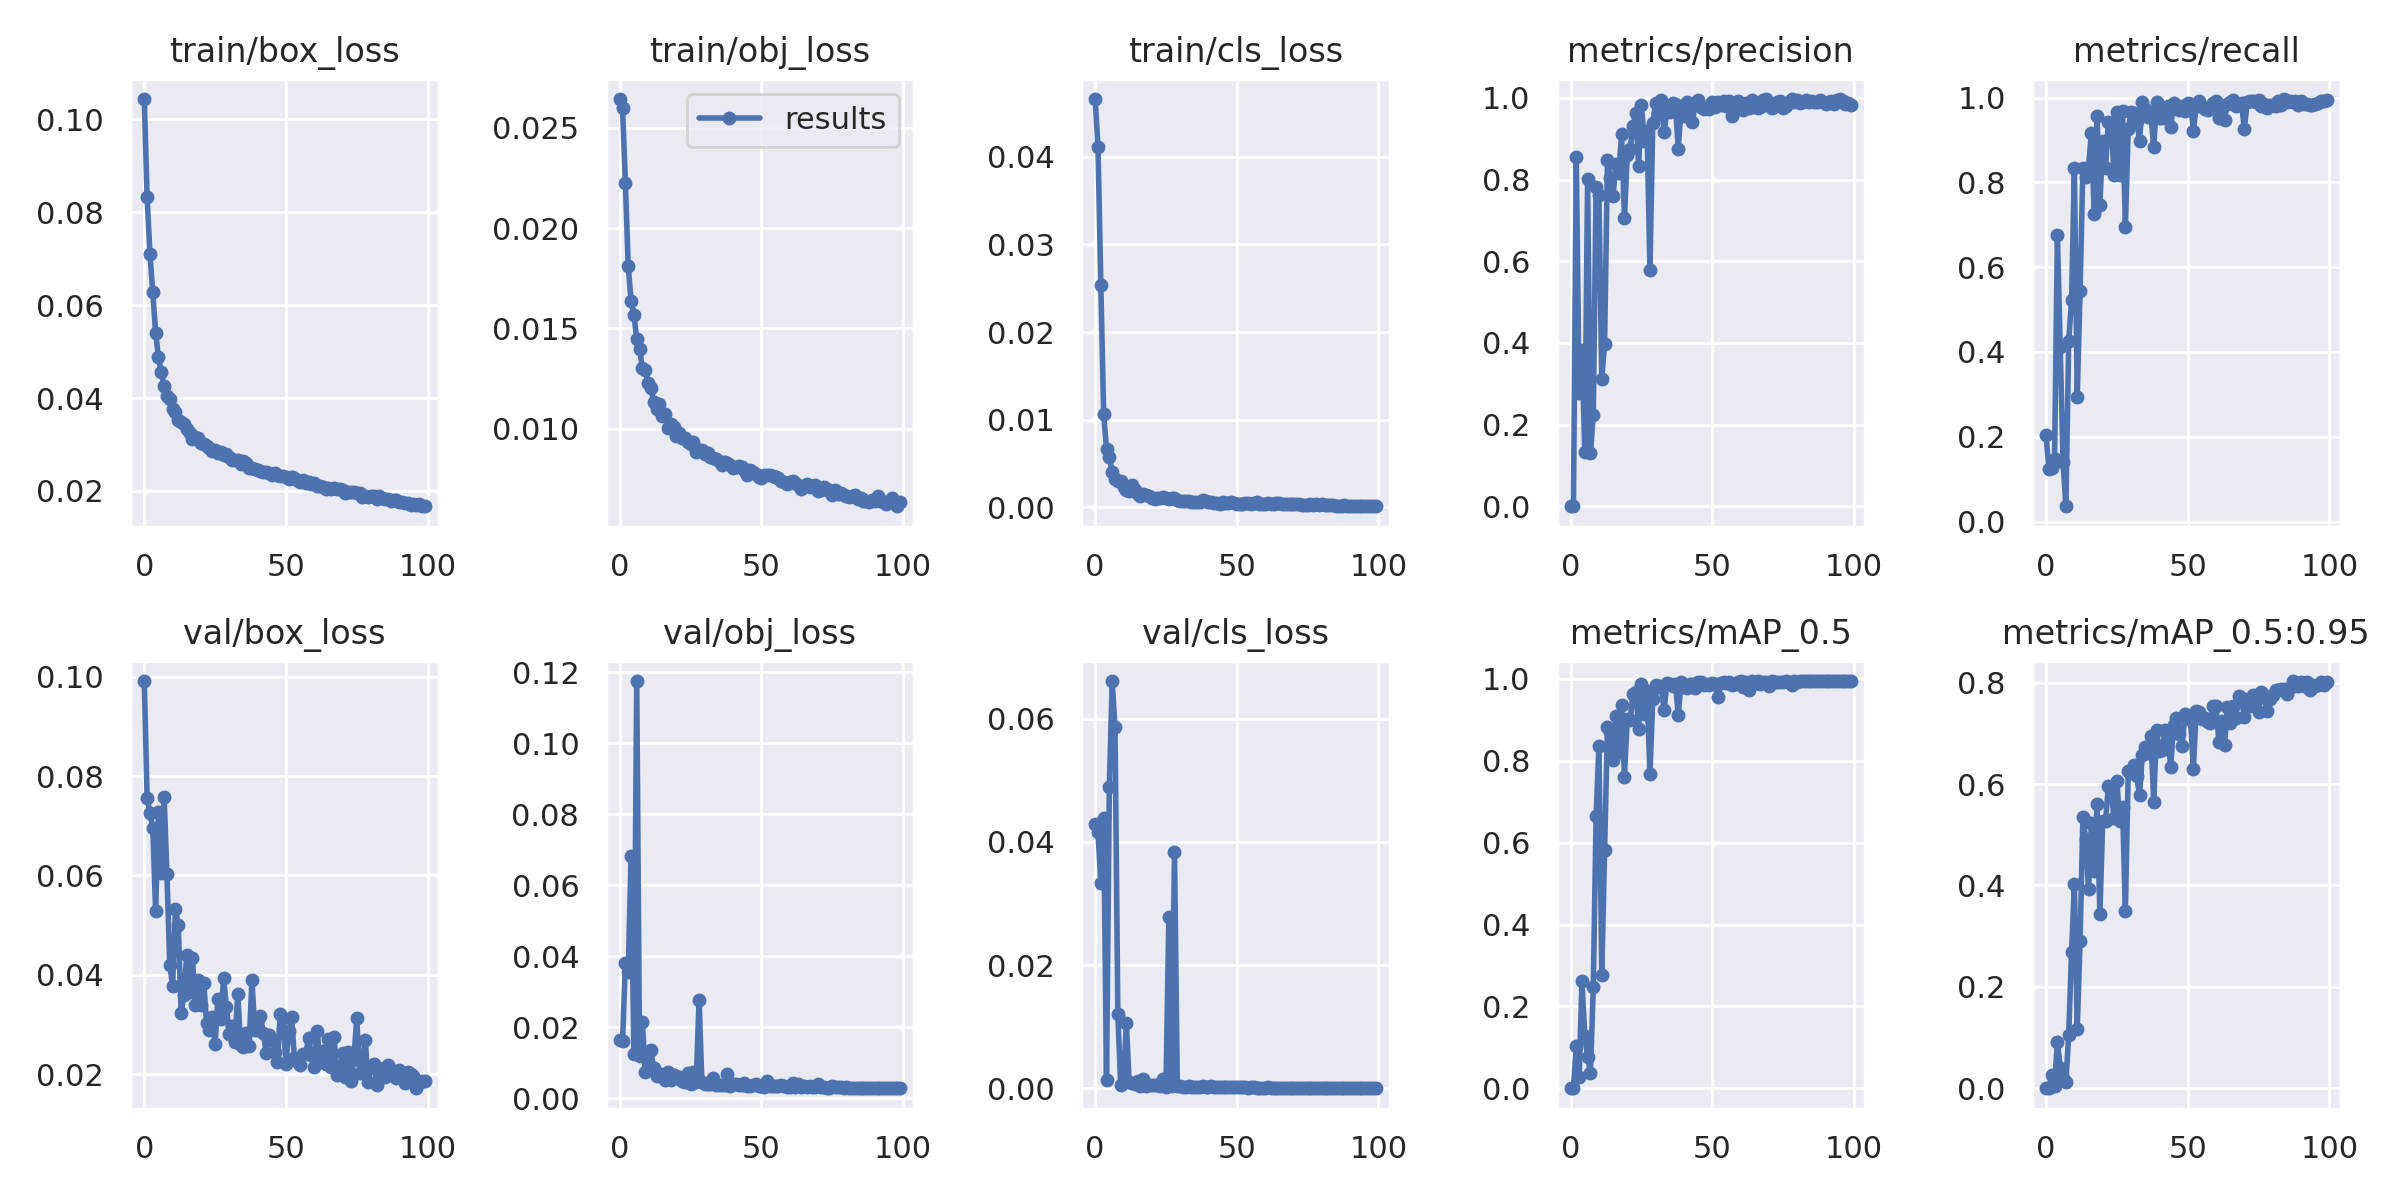

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results2/results.png', width=1000)  # view results.png

# Visualizing Training Data and Validation Data


GROUND TRUTH TRAINING DATA:


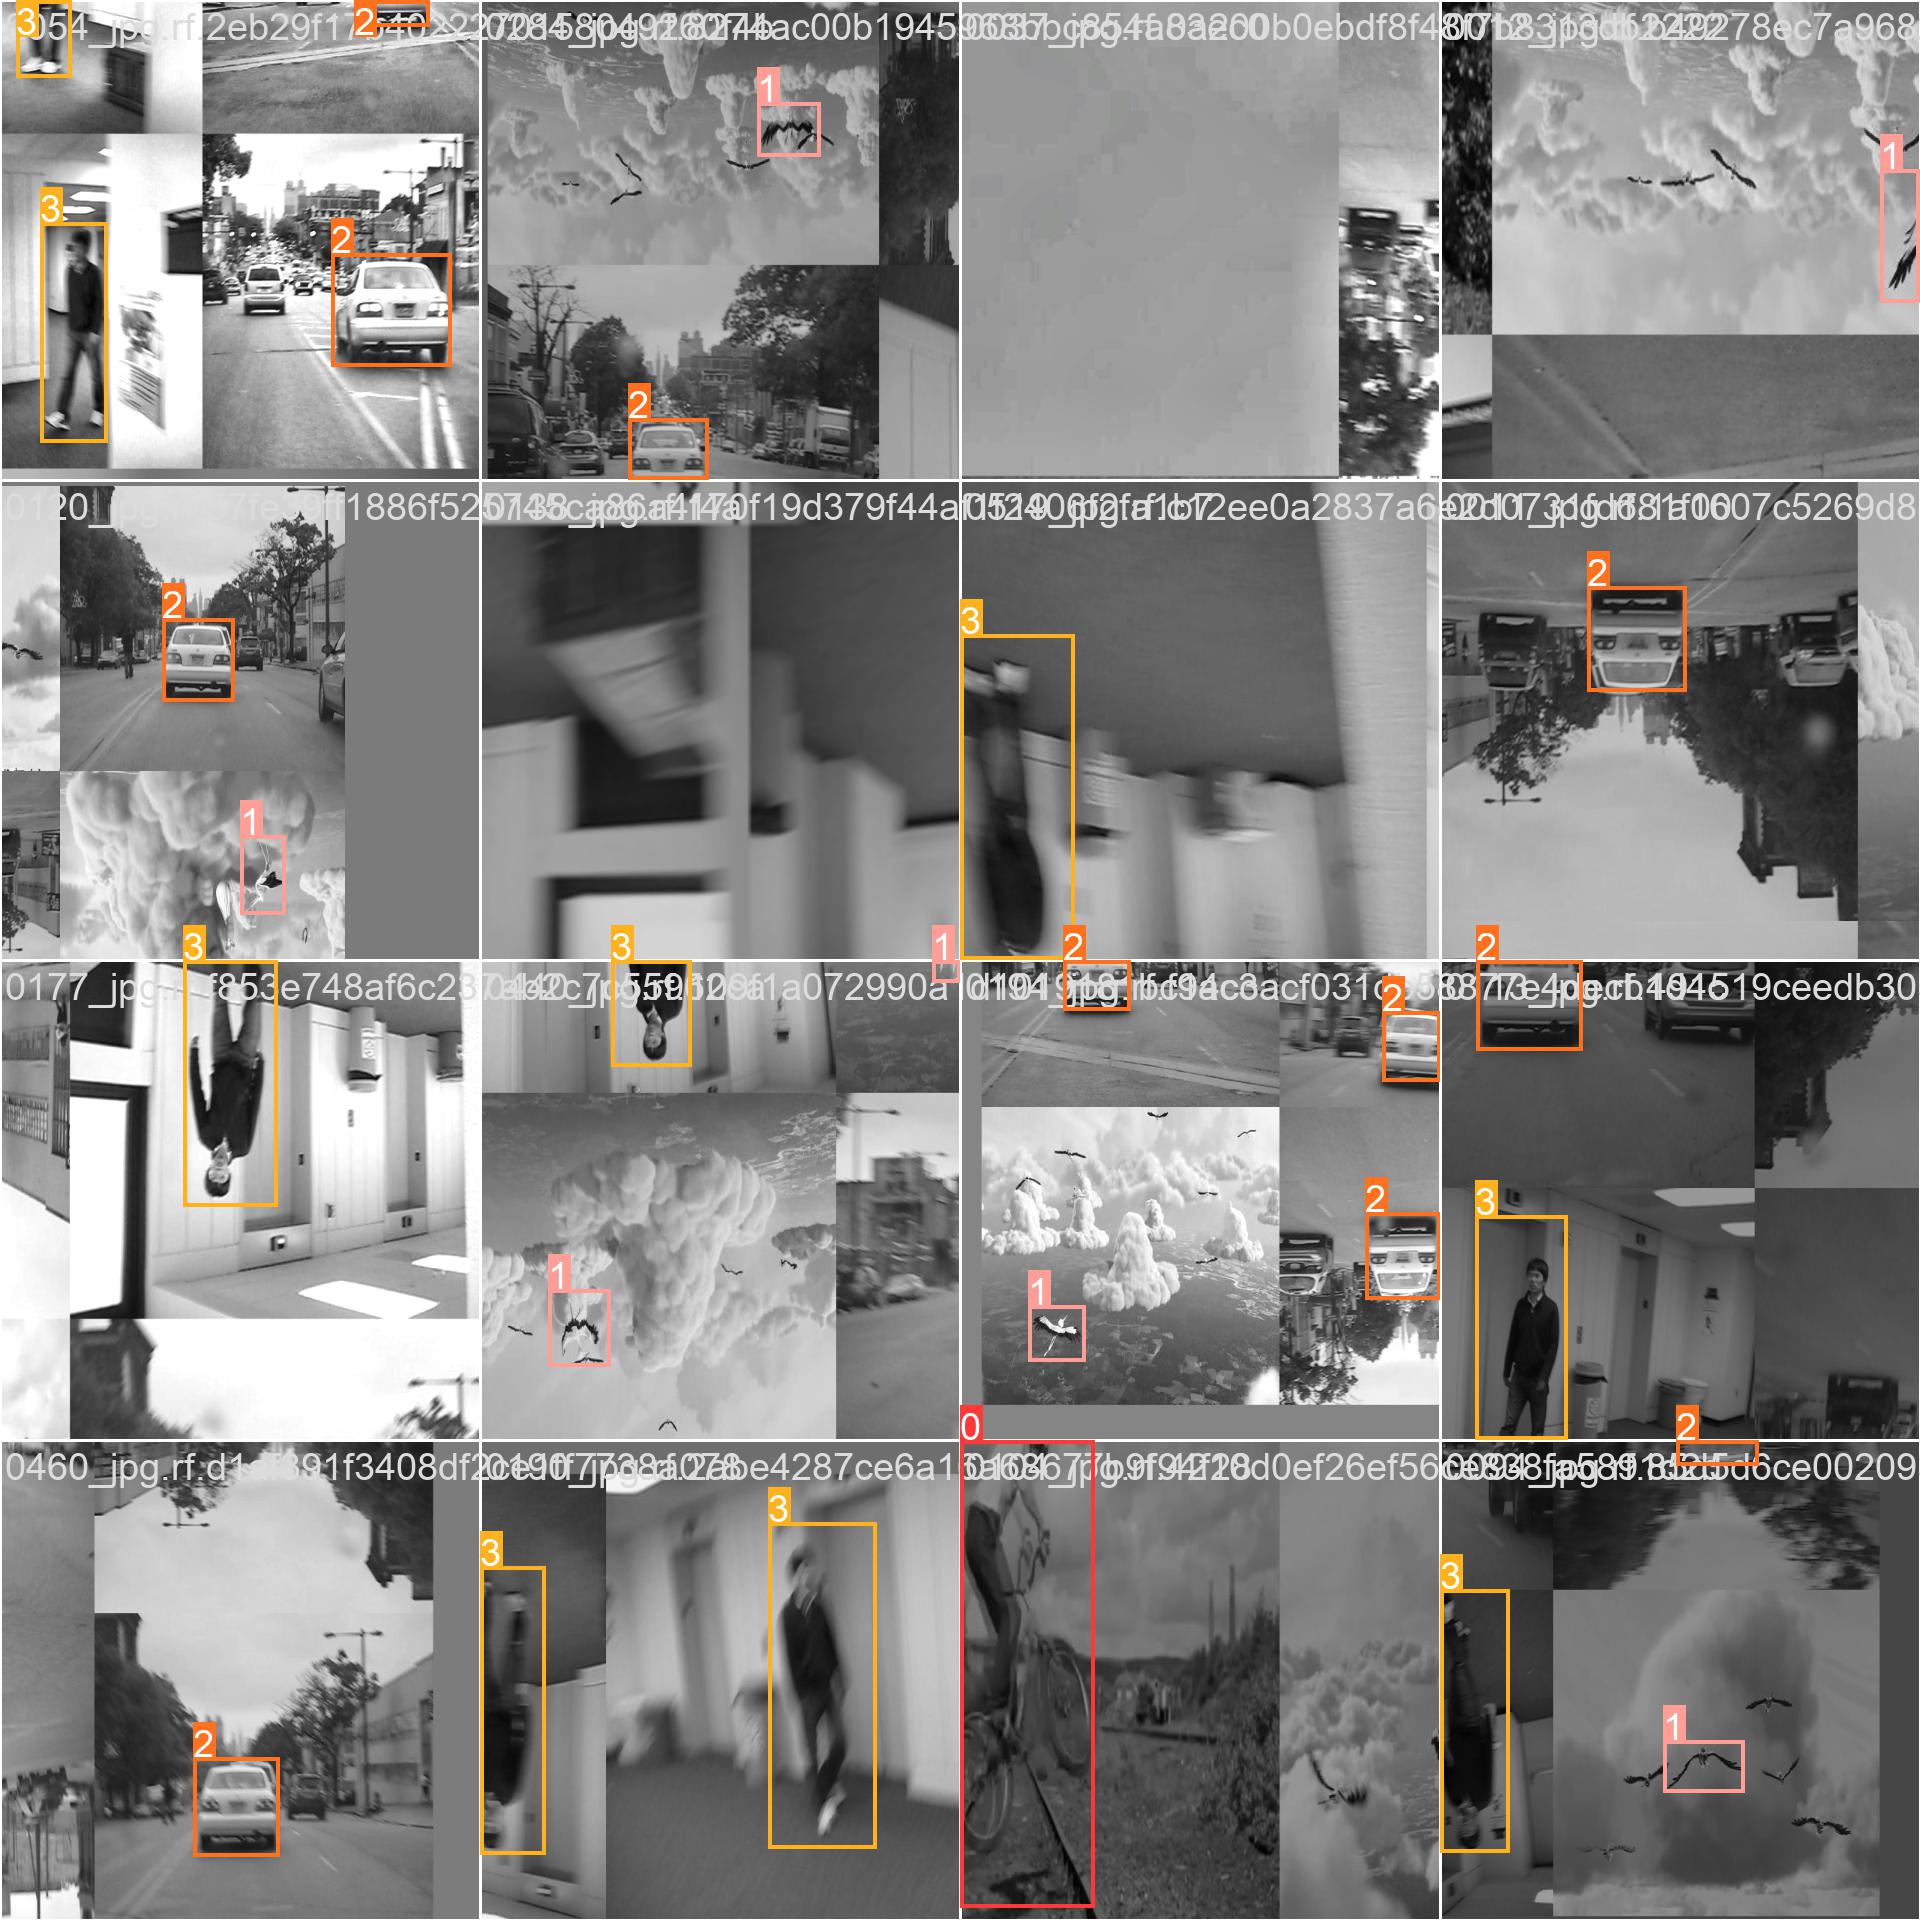

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results2/train_batch1.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


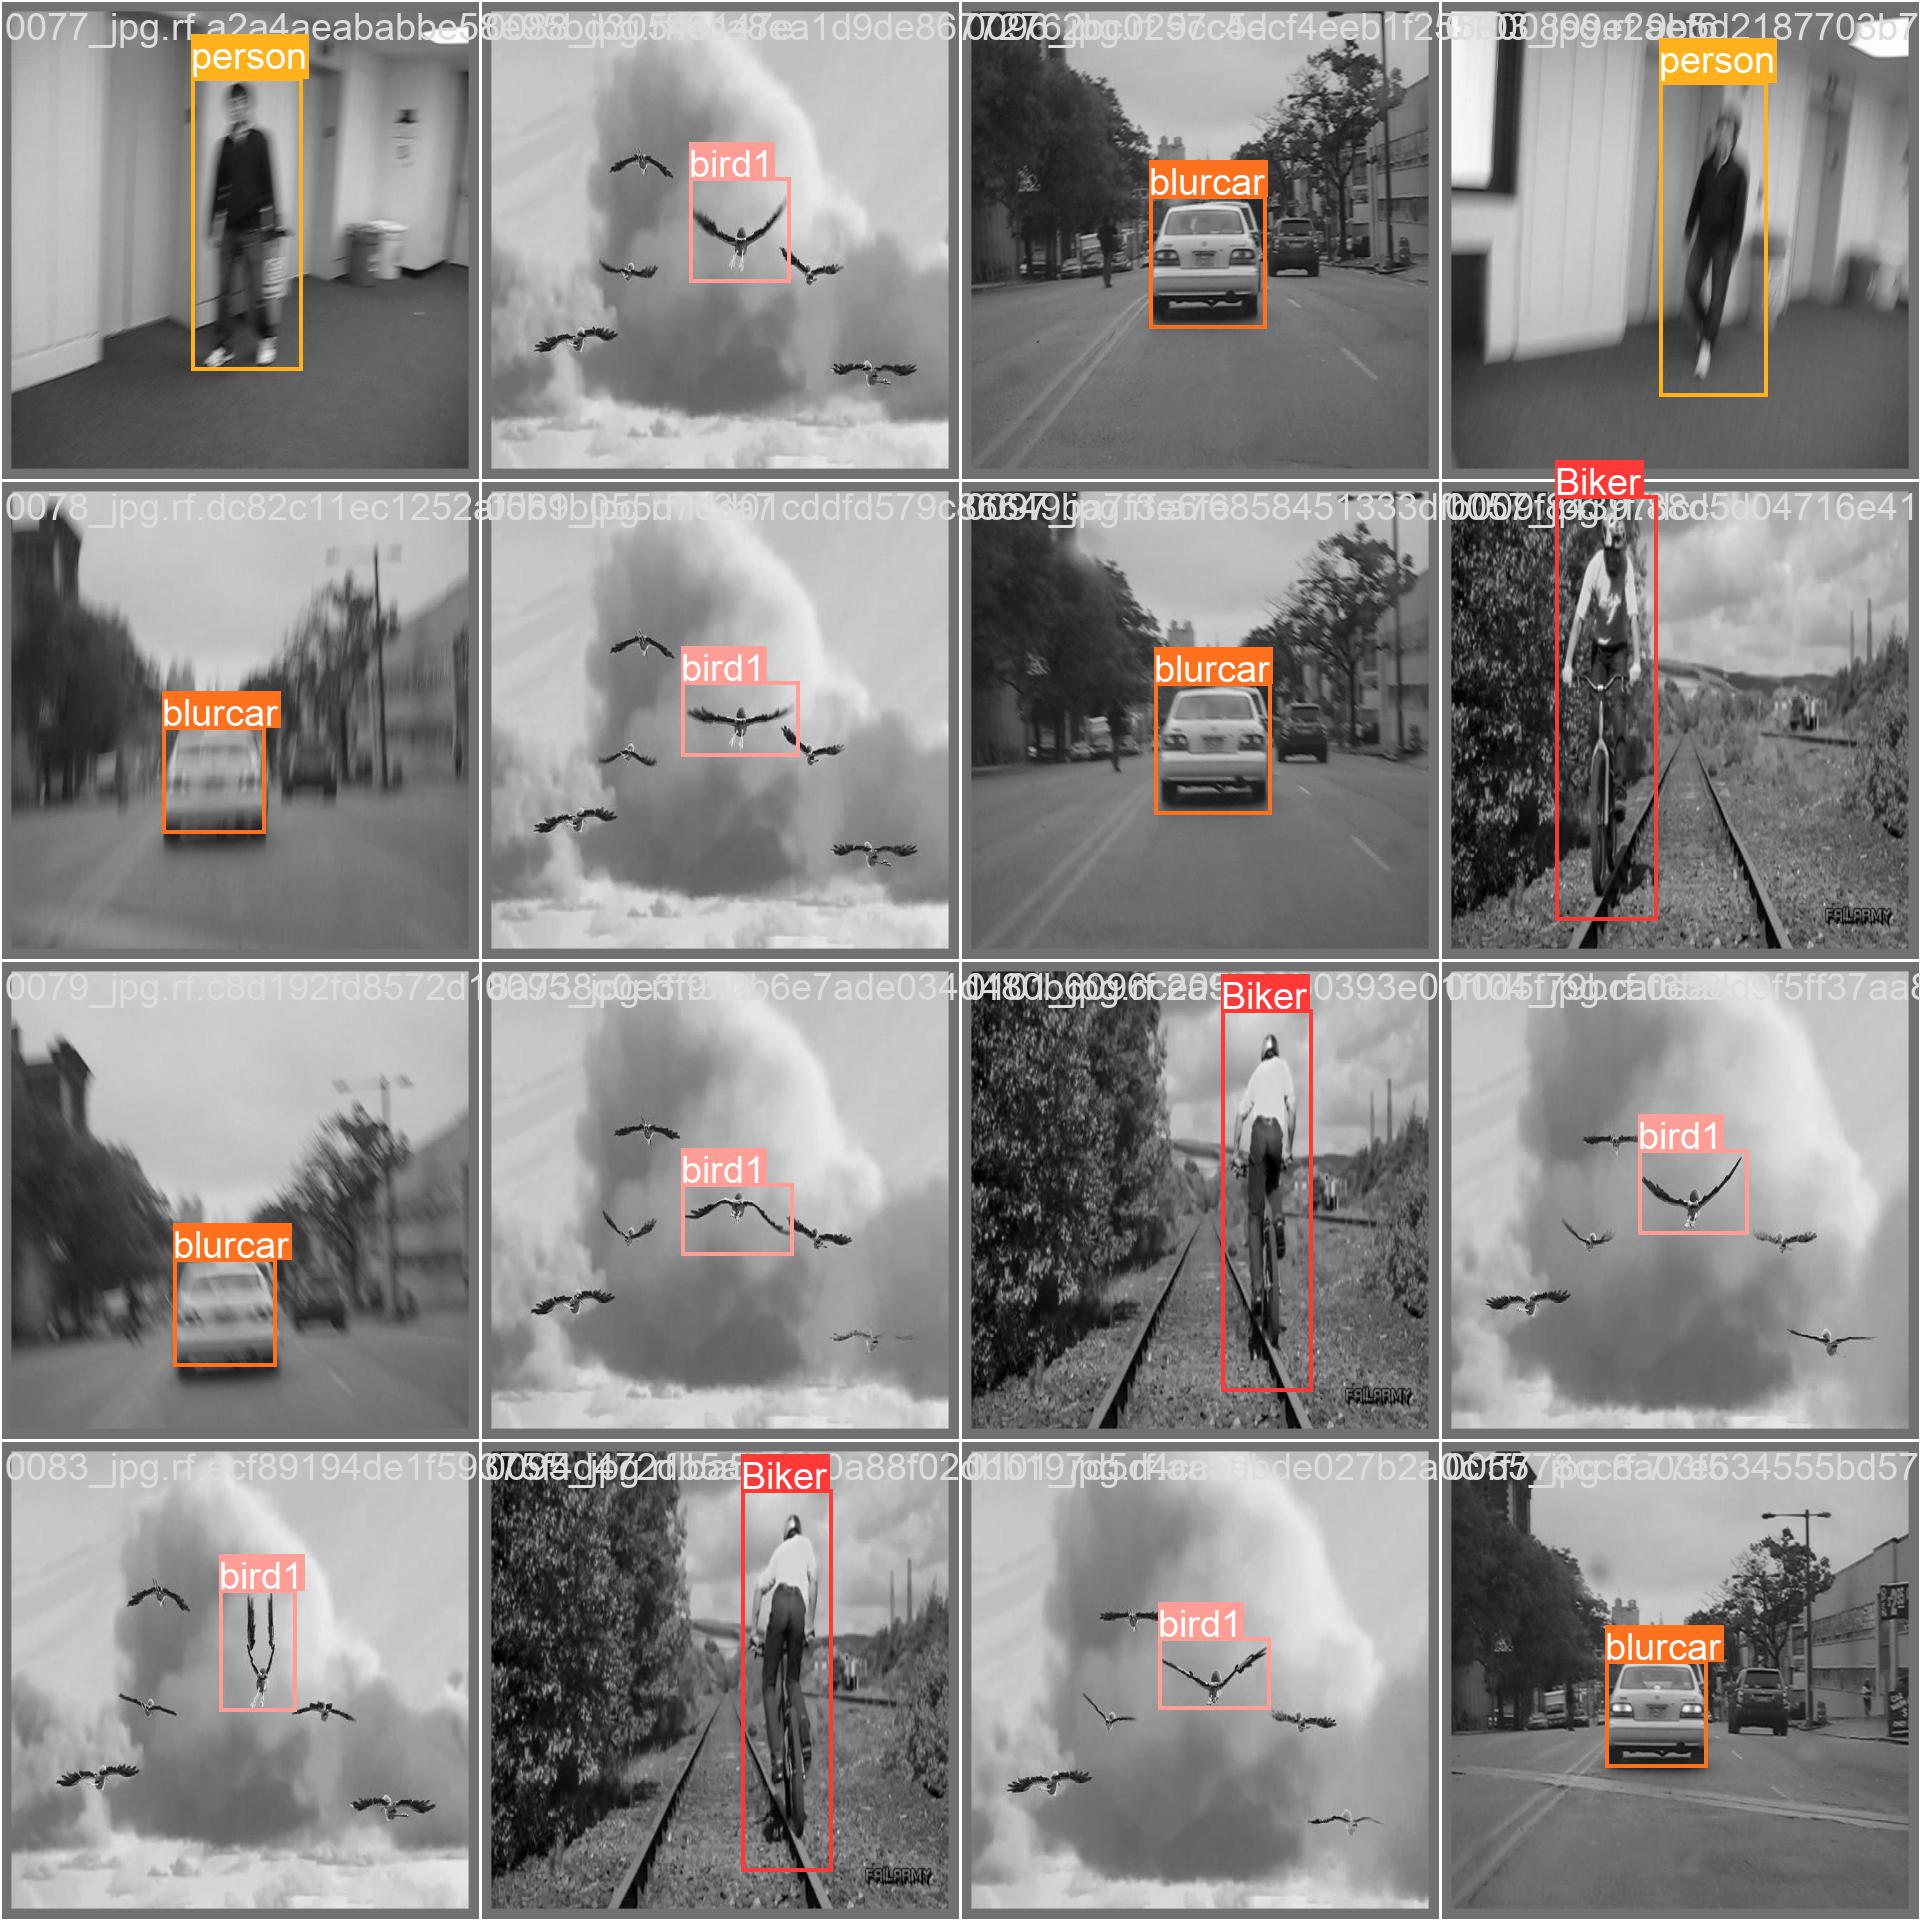

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results2/val_batch1_labels.jpg', width=900)

#Running best parameter from trained data on test images with threshold of 40%


In [ ]:
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 640 --conf 0.4 --source /content/yolov5/visual_object_tracking-2/test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results2/weights/best.pt'], source=/content/yolov5/visual_object_tracking-2/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-12-g7f5724b Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/165 /content/yolov5/visual_object_tracking-2/test/images/0003_jpg.rf.14f6e794281e7cf51749d48f4e02b65e.jpg: 640x640 1 person, 12.8ms
image 2/165 /content/yolov5/visual_object_tracking-2/test/images/0006_jpg.rf.234cbfe058b39afa3d8826f463f257c1.jpg: 640x640 1 Biker, 12.8ms
image

# Visualizing training images

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg'):
    display(Image(filename=imageName))
    print("\n")

# Saving Trained Weights on google drive for future use


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive

# Reference for the code 

https://roboflow.com/models/object-detection
